In [1]:
import numpy as np
import sys
import os
from astropy.table import Table
import matplotlib.pyplot as plt
sys.path.append('../src')
import P_binary
import parallax
import const as c
from scipy.stats import gaussian_kde
from scipy.integrate import quad

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
dtype = [('P_posterior','f8'), ('theta','f8'), ('distance','f8'), ('proj_sep','f8'),
         ('source_id_1','<i8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
#         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<i8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
#         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', dtype=dtype, names=True)

TGAS_power_law_false = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_false_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat_false = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_log_flat_false_cleaned.txt', dtype=dtype, names=True)

### Now, let's produce the union of the two catalogs

In [3]:
dtype2 = [('source_id_1','<i8'),('source_id_2','<i8'),('P_posterior_1','f8'),('P_posterior_2','f8')]

compare = np.zeros(len(TGAS_power_law), dtype=dtype2)
compare_zero = np.zeros(1, dtype=dtype2)

compare['source_id_1'] = TGAS_power_law['source_ID_1']
compare['source_id_2'] = TGAS_power_law['source_ID_2']
compare['P_posterior_1'] = TGAS_power_law['P_posterior']


for i in np.arange(len(TGAS_log_flat)):
#for i in np.arange(40):
    idx1 = np.where(TGAS_log_flat[i]['source_ID_1'] == compare['source_id_1']) 

    if len(idx1[0]) < 1: 
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_log_flat['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_log_flat['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_log_flat['P_posterior'][i]
        continue

    j_good = -1

    for j in idx1[0]:
        if TGAS_log_flat[i]['source_ID_2'] == compare[j]['source_id_2']:
            j_good = j

    if j_good == -1:
        compare = np.append(compare, compare_zero)
        compare[-1]['source_id_1'] = TGAS_log_flat['source_ID_1'][i]
        compare[-1]['source_id_2'] = TGAS_log_flat['source_ID_2'][i]
        compare[-1]['P_posterior_2'] = TGAS_log_flat['P_posterior'][i]
    else:
        compare[j_good]['P_posterior_2'] = TGAS_log_flat['P_posterior'][i]



In [4]:
dtype3 = [('source_id_1','<i8'), ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('source_id_2','<i8'), ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),         
         ('P_log_flat','f8'), ('P_power_law','f8'), ('theta','f8')]

idx = np.union1d(np.where(compare['P_posterior_1'] > 0.99)[0], np.where(compare['P_posterior_2'] > 0.99)[0])

TGAS_good = np.zeros(len(idx), dtype=dtype3)

for i in np.arange(len(idx)):
    
    if i%1000 == 0: print i
    
    idx_1 = -1
    idx_2 = -1

    # First, look for pair in TGAS_power_law
    for j in np.arange(len(TGAS_power_law)):
        if TGAS_power_law['source_ID_1'][j] == compare['source_id_1'][idx[i]] and \
                       TGAS_power_law['source_ID_2'][j] == compare['source_id_2'][idx[i]]:
            idx_1 = j
    
    # Next, look for pair in TGAS_log_flat
    for j in np.arange(len(TGAS_log_flat)):
        if TGAS_log_flat['source_ID_1'][j] == compare['source_id_1'][idx[i]] and \
                    TGAS_log_flat['source_ID_2'][j] == compare['source_id_2'][idx[i]]:
            idx_2 = j

            
    if idx_1 != -1:
        TGAS_good['source_id_1'][i] = TGAS_power_law['source_ID_1'][idx_1]
        TGAS_good['ra_1'][i] = TGAS_power_law['ra_1'][idx_1]
        TGAS_good['dec_1'][i] = TGAS_power_law['dec_1'][idx_1]
        TGAS_good['mu_ra_1'][i] = TGAS_power_law['mu_ra_1'][idx_1]
        TGAS_good['mu_dec_1'][i] = TGAS_power_law['mu_dec_1'][idx_1]
        TGAS_good['mu_ra_err_1'][i] = TGAS_power_law['mu_ra_err_1'][idx_1]
        TGAS_good['mu_dec_err_1'][i] = TGAS_power_law['mu_dec_err_1'][idx_1]
        TGAS_good['plx_1'][i] = TGAS_power_law['plx_1'][idx_1]
        TGAS_good['plx_err_1'][i] = TGAS_power_law['plx_err_1'][idx_1]
        TGAS_good['source_id_2'][i] = TGAS_power_law['source_ID_2'][idx_1]
        TGAS_good['ra_2'][i] = TGAS_power_law['ra_2'][idx_1]
        TGAS_good['dec_2'][i] = TGAS_power_law['dec_2'][idx_1]
        TGAS_good['mu_ra_2'][i] = TGAS_power_law['mu_ra_2'][idx_1]
        TGAS_good['mu_dec_2'][i] = TGAS_power_law['mu_dec_2'][idx_1]
        TGAS_good['mu_ra_err_2'][i] = TGAS_power_law['mu_ra_err_2'][idx_1]
        TGAS_good['mu_dec_err_2'][i] = TGAS_power_law['mu_dec_err_2'][idx_1]
        TGAS_good['plx_2'][i] = TGAS_power_law['plx_2'][idx_1]
        TGAS_good['plx_err_2'][i] = TGAS_power_law['plx_err_2'][idx_1]
        TGAS_good['theta'][i] = TGAS_power_law['theta'][idx_1]

    if idx_1 == -1 and idx_2 != -1:
        TGAS_good['source_id_1'][i] = TGAS_log_flat['source_ID_1'][idx_2]
        TGAS_good['ra_1'][i] = TGAS_log_flat['ra_1'][idx_2]
        TGAS_good['dec_1'][i] = TGAS_log_flat['dec_1'][idx_2]
        TGAS_good['mu_ra_1'][i] = TGAS_log_flat['mu_ra_1'][idx_2]
        TGAS_good['mu_dec_1'][i] = TGAS_log_flat['mu_dec_1'][idx_2]
        TGAS_good['mu_ra_err_1'][i] = TGAS_log_flat['mu_ra_err_1'][idx_2]
        TGAS_good['mu_dec_err_1'][i] = TGAS_log_flat['mu_dec_err_1'][idx_2]
        TGAS_good['plx_1'][i] = TGAS_log_flat['plx_1'][idx_2]
        TGAS_good['plx_err_1'][i] = TGAS_log_flat['plx_err_1'][idx_2]
        TGAS_good['source_id_2'][i] = TGAS_log_flat['source_ID_2'][idx_2]
        TGAS_good['ra_2'][i] = TGAS_log_flat['ra_2'][idx_2]
        TGAS_good['dec_2'][i] = TGAS_log_flat['dec_2'][idx_2]
        TGAS_good['mu_ra_2'][i] = TGAS_log_flat['mu_ra_2'][idx_2]
        TGAS_good['mu_dec_2'][i] = TGAS_log_flat['mu_dec_2'][idx_2]
        TGAS_good['mu_ra_err_2'][i] = TGAS_log_flat['mu_ra_err_2'][idx_2]
        TGAS_good['mu_dec_err_2'][i] = TGAS_log_flat['mu_dec_err_2'][idx_2]
        TGAS_good['plx_2'][i] = TGAS_log_flat['plx_2'][idx_2]
        TGAS_good['plx_err_2'][i] = TGAS_log_flat['plx_err_2'][idx_2]
        TGAS_good['theta'][i] = TGAS_log_flat['theta'][idx_2]

        
    # Now, the posterior probabilities
    if idx_1 != -1:
        TGAS_good['P_power_law'][i] = TGAS_power_law['P_posterior'][idx_1]
    else:
        TGAS_good['P_power_law'][i] = 0.0

    if idx_2 != -1:
        TGAS_good['P_log_flat'][i] = TGAS_log_flat['P_posterior'][idx_2]
    else:
        TGAS_good['P_log_flat'][i] = 0.0





        
        

0
1000


KeyboardInterrupt: 

In [5]:
print len(TGAS_good)
print len(TGAS_good[TGAS_good['P_power_law'] < 0.99])
print len(TGAS_good[TGAS_good['P_log_flat'] < 0.99])

6194
1475
125


In [20]:
tgas_table_partial = Table(np.sort(TGAS_good, order='ra_1')[0:9])
filename = '../data/TGAS/tgas_catalog_partial.tex'
tgas_table_partial.write(filename, format='latex')


tgas_table = Table(np.sort(TGAS_good, order='ra_1'))
filename = '../data/TGAS/tgas_catalog.csv'
tgas_table.write(filename, format='csv')

### Select systems in the corners

In [20]:
# Print numbers at bottom right and top left
n_bottom_left = 0
n_bottom_right = 0
n_top_left = 0
n_top_right = 0

for i in np.arange(len(compare)):
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] > 0.9: n_top_right = n_top_right+1
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] < 0.1: n_bottom_right = n_bottom_right+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.9: n_top_left = n_top_left+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: n_bottom_left = n_bottom_left+1

print "Top right:", n_top_right
print "Bottom right:", n_bottom_right
print "Top left:", n_top_left
print "Bottom left:", n_bottom_left

Top right: 5927
Bottom right: 95
Top left: 377
Bottom left: 13885


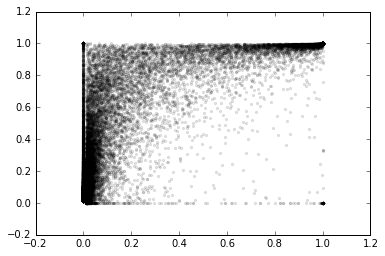

In [21]:
plt.scatter(compare['P_posterior_1'], compare['P_posterior_2'], marker='.', color='k', alpha=0.1)



plt.show()

In [9]:
#### LOG FLAT ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_log_flat = np.zeros(len(TGAS_log_flat))
for i in np.arange(len(TGAS_log_flat)):
    vals = [TGAS_log_flat['plx_1'][i],TGAS_log_flat['plx_2'][i]]
    weights = [1.0/TGAS_log_flat['plx_err_1'][i],1.0/TGAS_log_flat['plx_err_2'][i]]
    dist_log_flat[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_log_flat = (TGAS_log_flat['theta']*np.pi/180.0/3600.0) * dist_log_flat * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_log_flat = np.sqrt(TGAS_log_flat['mu_ra_1']**2 + TGAS_log_flat['mu_dec_1']**2)
delta_mu_log_flat = np.sqrt((TGAS_log_flat['mu_ra_1']-TGAS_log_flat['mu_ra_2'])**2 + (TGAS_log_flat['mu_dec_1']-TGAS_log_flat['mu_dec_2'])**2)

# values for "good" pairs only
dist_log_flat_good = dist_log_flat[TGAS_log_flat['P_posterior'] > 0.99]
s_log_flat_good = s_log_flat[TGAS_log_flat['P_posterior'] > 0.99]



#### POWER LAW ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_power_law = np.zeros(len(TGAS_power_law))
for i in np.arange(len(TGAS_power_law)):
    vals = [TGAS_power_law['plx_1'][i],TGAS_power_law['plx_2'][i]]
    weights = [1.0/TGAS_power_law['plx_err_1'][i],1.0/TGAS_power_law['plx_err_2'][i]]
    dist_power_law[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_power_law = (TGAS_power_law['theta']*np.pi/180.0/3600.0) * dist_power_law * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_power_law = np.sqrt(TGAS_power_law['mu_ra_1']**2 + TGAS_power_law['mu_dec_1']**2)
delta_mu_power_law = np.sqrt((TGAS_power_law['mu_ra_1']-TGAS_power_law['mu_ra_2'])**2 + (TGAS_power_law['mu_dec_1']-TGAS_power_law['mu_dec_2'])**2)

# values for "good" pairs only
dist_power_law_good = dist_power_law[TGAS_power_law['P_posterior'] > 0.99]
s_power_law_good = s_power_law[TGAS_power_law['P_posterior'] > 0.99]

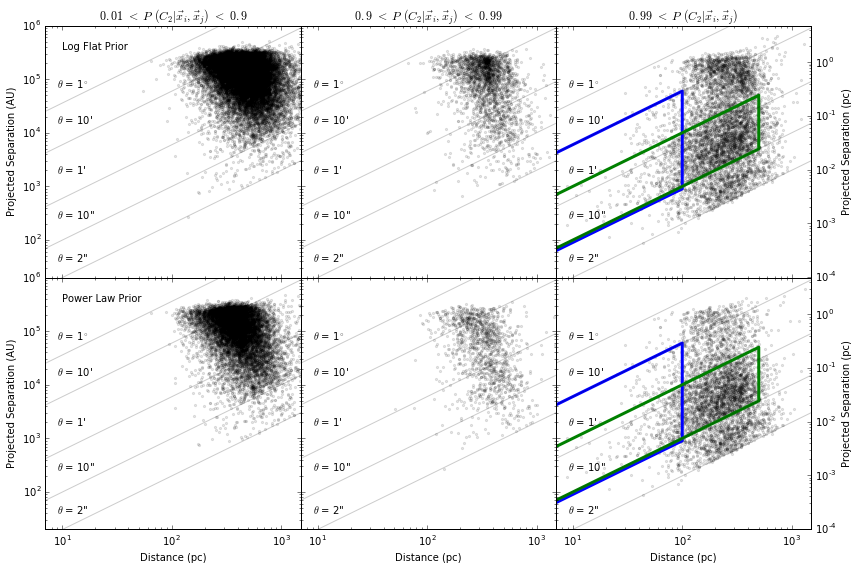

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))


tmp_x = 10**np.linspace(0.1,3.5,100)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_1deg = (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10deg = 10.0 * (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)


# Log flat
idx = np.where(TGAS_log_flat['P_posterior'] < 0.9)
ax[0,0].scatter(dist_log_flat[idx], s_log_flat[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.intersect1d(np.where(TGAS_log_flat['P_posterior'] > 0.9)[0], np.where(TGAS_log_flat['P_posterior'] < 0.99)[0])
ax[0,1].scatter(dist_log_flat[idx], s_log_flat[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.where(TGAS_log_flat['P_posterior'] > 0.99)
ax[0,2].scatter(dist_log_flat[idx], s_log_flat[idx], marker='.', color='k', alpha=0.1, rasterized=True)

# Power law
idx = np.where(TGAS_power_law['P_posterior'] < 0.9)
ax[1,0].scatter(dist_power_law[idx], s_power_law[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.intersect1d(np.where(TGAS_power_law['P_posterior'] > 0.9)[0], np.where(TGAS_power_law['P_posterior'] < 0.99)[0])
ax[1,1].scatter(dist_power_law[idx], s_power_law[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.where(TGAS_power_law['P_posterior'] > 0.99)
ax[1,2].scatter(dist_power_law[idx], s_power_law[idx], marker='.', color='k', alpha=0.1, rasterized=True)






x_region = np.array([0.01, 100.0, 100.0, 0.01])
y_region = 600. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm) 
y_region[3] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm) 
for i in np.arange(2):
#     for j in np.arange(3):
#        ax[i,j].plot(x_region, y_region, color='b', linewidth=3.0, linestyle='dashed')
    ax[i,2].plot(x_region, y_region, color='b', linewidth=3.0, linestyle='solid')

    
x_region = np.array([0.01, 500.0, 500.0, 0.01])
y_region = 100. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm)
y_region[3] = 10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm)
for i in np.arange(2):
#     for j in np.arange(3):
#         ax[i,j].plot(x_region, y_region, color='g', linewidth=3.0, linestyle='dashed')
    ax[i,2].plot(x_region, y_region, color='g', linewidth=3.0, linestyle='solid')




for i in np.arange(2):
    for j in np.arange(3):

        ax[i,j].plot(tmp_x, tmp_y_2as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 40., r'$\theta$ = 2"')
        ax[i,j].plot(tmp_x, tmp_y_10as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 250., r'$\theta$ = 10"')
        ax[i,j].plot(tmp_x, tmp_y_60as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 1700., r"$\theta$ = 1'")
        ax[i,j].plot(tmp_x, tmp_y_600as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 15000., r"$\theta$ = 10'")
        ax[i,j].plot(tmp_x, tmp_y_1deg, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 7.0e4, r"$\theta$ = 1$^{\circ}$")

        ax[i,j].set_xlim(7.0, 1500.0)
        ax[i,j].set_ylim(20.0, 1.0e6)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
#         ax[i,j].axhline(1.0*c.pc_to_cm/c.AU_to_cm, color='k', linestyle='dotted')

        if i != 1:
            ax[i,j].set_xticklabels([])
        if j != 0:
            ax[i,j].set_yticklabels([])

        if i != 0:
            ax[i,j].set_xlabel("Distance (pc)")
    

ax2 = ax[0,2].twinx()
y2_min = ax[0,2].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y2_max = ax[0,2].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax2.set_ylim(y2_min, y2_max)
ax2.set_yscale('log')
ax2.set_ylabel('Projected Separation (pc)')

ax3 = ax[1,2].twinx()
y3_min = ax[1,2].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y3_max = ax[1,2].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax3.set_ylim(y3_min, y3_max)
ax3.set_yscale('log')
ax3.set_ylabel('Projected Separation (pc)')


ax[1,0].text(10.0, 3.5e5, "Power Law Prior")
ax[0,0].text(10.0, 3.5e5, "Log Flat Prior")




ax[0,0].set_ylabel("Projected Separation (AU)")
ax[1,0].set_ylabel("Projected Separation (AU)")

ax[0,0].set_title(r'$0.01\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.9$')
ax[0,1].set_title(r'$0.9\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.99$')
ax[0,2].set_title(r'$0.99\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)$')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../figures/TGAS_dist_s_theta.pdf')
# plt.show()

### Let's repeat the same analysis as above, but for known false pairs

In [5]:
#### LOG FLAT FALSE ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_log_flat_false = np.zeros(len(TGAS_log_flat_false))
for i in np.arange(len(TGAS_log_flat_false)):
    vals = [TGAS_log_flat_false['plx_1'][i],TGAS_log_flat_false['plx_2'][i]]
    weights = [1.0/TGAS_log_flat_false['plx_err_1'][i],1.0/TGAS_log_flat_false['plx_err_2'][i]]
    dist_log_flat_false[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_log_flat_false = (TGAS_log_flat_false['theta']*np.pi/180.0/3600.0) * dist_log_flat_false * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_log_flat_false = np.sqrt(TGAS_log_flat_false['mu_ra_1']**2 + TGAS_log_flat_false['mu_dec_1']**2)
delta_mu_log_flat_false = np.sqrt((TGAS_log_flat_false['mu_ra_1']-TGAS_log_flat_false['mu_ra_2'])**2 + (TGAS_log_flat_false['mu_dec_1']-TGAS_log_flat_false['mu_dec_2'])**2)

# values for "good" pairs only
dist_log_flat_false_good = dist_log_flat_false[TGAS_log_flat_false['P_posterior'] > 0.99]
s_log_flat_false_good = s_log_flat_false[TGAS_log_flat_false['P_posterior'] > 0.99]


#### POWER LAW FALSE ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_power_law_false = np.zeros(len(TGAS_power_law_false))
for i in np.arange(len(TGAS_power_law_false)):
    vals = [TGAS_power_law_false['plx_1'][i],TGAS_power_law_false['plx_2'][i]]
    weights = [1.0/TGAS_power_law_false['plx_err_1'][i],1.0/TGAS_power_law_false['plx_err_2'][i]]
    dist_power_law_false[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_power_law_false = (TGAS_power_law_false['theta']*np.pi/180.0/3600.0) * dist_power_law_false * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_power_law_false = np.sqrt(TGAS_power_law_false['mu_ra_1']**2 + TGAS_power_law_false['mu_dec_1']**2)
delta_mu_power_law_false = np.sqrt((TGAS_power_law_false['mu_ra_1']-TGAS_power_law_false['mu_ra_2'])**2 + (TGAS_power_law_false['mu_dec_1']-TGAS_power_law_false['mu_dec_2'])**2)

# values for "good" pairs only
dist_power_law_false_good = dist_power_law_false[TGAS_power_law_false['P_posterior'] > 0.99]
s_power_law_false_good = s_power_law_false[TGAS_power_law_false['P_posterior'] > 0.99]


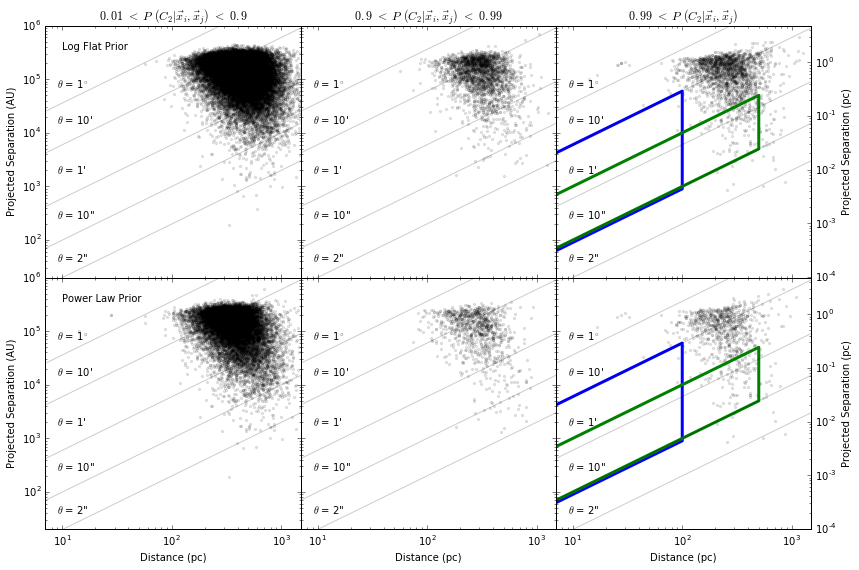

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))


tmp_x = 10**np.linspace(0.1,3.5,100)
tmp_y_2as = 2. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10as = 10. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_60as = 60. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_600as = 600. * (np.pi/180.0/3600.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_1deg = (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)
tmp_y_10deg = 10.0 * (np.pi/180.0) * tmp_x * (c.pc_to_cm/c.AU_to_cm)


# Log flat
idx = np.where(TGAS_log_flat_false['P_posterior'] < 0.9)
ax[0,0].scatter(dist_log_flat_false[idx], s_log_flat_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.intersect1d(np.where(TGAS_log_flat_false['P_posterior'] > 0.9)[0], np.where(TGAS_log_flat_false['P_posterior'] < 0.99)[0])
ax[0,1].scatter(dist_log_flat_false[idx], s_log_flat_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.where(TGAS_log_flat_false['P_posterior'] > 0.99)
ax[0,2].scatter(dist_log_flat_false[idx], s_log_flat_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)

# Power law
idx = np.where(TGAS_power_law_false['P_posterior'] < 0.9)
ax[1,0].scatter(dist_power_law_false[idx], s_power_law_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.intersect1d(np.where(TGAS_power_law_false['P_posterior'] > 0.9)[0], np.where(TGAS_power_law_false['P_posterior'] < 0.99)[0])
ax[1,1].scatter(dist_power_law_false[idx], s_power_law_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)
idx = np.where(TGAS_power_law_false['P_posterior'] > 0.99)
ax[1,2].scatter(dist_power_law_false[idx], s_power_law_false[idx], marker='.', color='k', alpha=0.1, rasterized=True)






x_region = np.array([0.01, 100.0, 100.0, 0.01])
y_region = 600. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm) 
y_region[3] = 0.9*10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm) 
for i in np.arange(2):
#     for j in np.arange(3):
#        ax[i,j].plot(x_region, y_region, color='b', linewidth=3.0, linestyle='dashed')
    ax[i,2].plot(x_region, y_region, color='b', linewidth=3.0, linestyle='solid')

    
x_region = np.array([0.01, 500.0, 500.0, 0.01])
y_region = 100. * (np.pi/180.0/3600.0) * x_region * (c.pc_to_cm/c.AU_to_cm)
y_region[2] = 10. * (np.pi/180.0/3600.0) * x_region[2] * (c.pc_to_cm/c.AU_to_cm)
y_region[3] = 10. * (np.pi/180.0/3600.0) * x_region[3] * (c.pc_to_cm/c.AU_to_cm)
for i in np.arange(2):
#     for j in np.arange(3):
#         ax[i,j].plot(x_region, y_region, color='g', linewidth=3.0, linestyle='dashed')
    ax[i,2].plot(x_region, y_region, color='g', linewidth=3.0, linestyle='solid')




for i in np.arange(2):
    for j in np.arange(3):

        ax[i,j].plot(tmp_x, tmp_y_2as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 40., r'$\theta$ = 2"')
        ax[i,j].plot(tmp_x, tmp_y_10as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 250., r'$\theta$ = 10"')
        ax[i,j].plot(tmp_x, tmp_y_60as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 1700., r"$\theta$ = 1'")
        ax[i,j].plot(tmp_x, tmp_y_600as, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 15000., r"$\theta$ = 10'")
        ax[i,j].plot(tmp_x, tmp_y_1deg, color='k', linestyle='solid', alpha=0.2)
        ax[i,j].text(9.0, 7.0e4, r"$\theta$ = 1$^{\circ}$")

        ax[i,j].set_xlim(7.0, 1500.0)
        ax[i,j].set_ylim(20.0, 1.0e6)
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
#         ax[i,j].axhline(1.0*c.pc_to_cm/c.AU_to_cm, color='k', linestyle='dotted')

        if i != 1:
            ax[i,j].set_xticklabels([])
        if j != 0:
            ax[i,j].set_yticklabels([])

        if i != 0:
            ax[i,j].set_xlabel("Distance (pc)")
    

ax2 = ax[0,2].twinx()
y2_min = ax[0,2].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y2_max = ax[0,2].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax2.set_ylim(y2_min, y2_max)
ax2.set_yscale('log')
ax2.set_ylabel('Projected Separation (pc)')

ax3 = ax[1,2].twinx()
y3_min = ax[1,2].get_ylim()[0] * c.AU_to_cm/c.pc_to_cm
y3_max = ax[1,2].get_ylim()[1] * c.AU_to_cm/c.pc_to_cm
ax3.set_ylim(y3_min, y3_max)
ax3.set_yscale('log')
ax3.set_ylabel('Projected Separation (pc)')


ax[1,0].text(10.0, 3.5e5, "Power Law Prior")
ax[0,0].text(10.0, 3.5e5, "Log Flat Prior")




ax[0,0].set_ylabel("Projected Separation (AU)")
ax[1,0].set_ylabel("Projected Separation (AU)")

ax[0,0].set_title(r'$0.01\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.9$')
ax[0,1].set_title(r'$0.9\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)\ <\ 0.99$')
ax[0,2].set_title(r'$0.99\ <\ P\ (C_2 | \vec{x}_i, \vec{x}_j)$')


plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../figures/TGAS_dist_s_theta_false.pdf')
# plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/Library/Python/2.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in log10


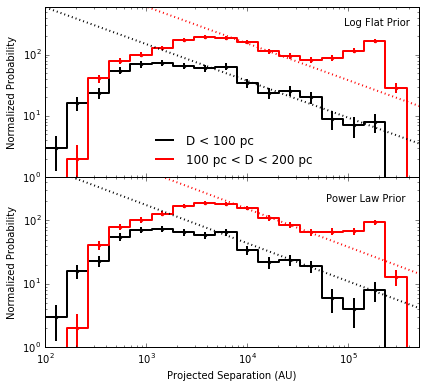

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))

idx_log_flat_100 = np.where(dist_log_flat_good<100.0)
idx_log_flat_100_150 = np.intersect1d(np.where(dist_log_flat_good<150.0)[0], np.where(dist_log_flat_good>100.0)[0])
idx_log_flat_150_200 = np.intersect1d(np.where(dist_log_flat_good<200.0)[0], np.where(dist_log_flat_good>150.0)[0])
idx_log_flat_100_200 = np.intersect1d(np.where(dist_log_flat_good<200.0)[0], np.where(dist_log_flat_good>100.0)[0])
idx_log_flat_200 = np.where(dist_log_flat_good<200.0)

idx_power_law_100 = np.where(dist_power_law_good<100.0)
idx_power_law_100_150 = np.intersect1d(np.where(dist_power_law_good<150.0)[0], np.where(dist_power_law_good>100.0)[0])
idx_power_law_150_200 = np.intersect1d(np.where(dist_power_law_good<200.0)[0], np.where(dist_power_law_good>150.0)[0])
idx_power_law_100_200 = np.intersect1d(np.where(dist_power_law_good<200.0)[0], np.where(dist_power_law_good>100.0)[0])
idx_power_law_200 = np.where(dist_power_law_good<200.0)


xmin, xmax = 2.0, 6.0
bins = np.linspace(xmin, xmax, 20)
center = (bins[:-1] + bins[1:]) / 2
#vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_100]), bins=bins, normed=True)
vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_100]), bins=bins)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[1].plot(X, Y, color='k', linewidth=2.0)
# ax[0].plot(10**bins[1:], vals, ls='steps', color='k', linewidth=2.0, label='D < 100 pc')
ax[1].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='k', elinewidth=2)
#vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_100_150]), bins=bins, normed=True)
vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_100_200]), bins=bins)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[1].plot(X, Y, color='r', linewidth=2.0)
ax[1].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='r', elinewidth=2)
# ax[0].plot(10**bins[1:], vals, ls='steps', color='r', linewidth=2.0, label='100 pc < D < 200 pc')
#vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_150_200]), bins=bins, normed=True)
# vals, bins = np.histogram(np.log10(s_power_law_good[idx_power_law_150_200]), bins=bins)
# yerr = np.sqrt(vals)
# ax[0].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='c', elinewidth=2)
# ax[0].plot(10**bins[1:], vals, ls='steps', color='c', linewidth=2.0, label='150 pc < D < 200 pc')
ax[1].set_xscale('log')



xmin, xmax = 2.0, 6.0
bins = np.linspace(xmin, xmax, 20)
center = (bins[:-1] + bins[1:]) / 2
#vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_100]), bins=bins, normed=True)
vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_100]), bins=bins)
# yerr = np.sqrt(vals)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[0].plot(X, Y, color='k', linewidth=2.0, label='D < 100 pc')
# ax[1].plot(10**bins[1:], vals, ls='steps', color='k', linewidth=2.0)
ax[0].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='k', elinewidth=2)
#vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_100_150]), bins=bins, normed=True)
vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_100_200]), bins=bins)
yerr = np.sqrt(vals)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[0].plot(X, Y, color='r', linewidth=2.0, label='100 pc < D < 200 pc')
# ax[1].plot(10**bins[1:], vals, ls='steps', color='r', linewidth=2.0)
ax[0].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='r', elinewidth=2)
#vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_150_200]), bins=bins, normed=True)
# vals, bins = np.histogram(np.log10(s_log_flat_good[idx_log_flat_150_200]), bins=bins)
# yerr = np.sqrt(vals)
# ax[1].errorbar(10**center, vals, yerr=yerr, fmt='.', capsize=0, color='c', elinewidth=2)
# ax[1].plot(10**bins[1:], vals, ls='steps', color='c', linewidth=2.0)
ax[0].set_xscale('log')



tmp_x = 10.0**np.linspace(2.0, 6.0, 10)
tmp_y = 1.1e4*tmp_x**-0.6
ax[0].plot(tmp_x, 0.85*tmp_y, color='k', linestyle='dotted', linewidth=2.0)
ax[1].plot(tmp_x, tmp_y, color='k', label=r'$f\ (s)\sim s^{-1.6}$', linestyle='dotted', linewidth=2.0)

tmp_x = 10.0**np.linspace(2.0, 6.0, 10)
tmp_y = 4.5e4*tmp_x**-0.6
ax[0].plot(tmp_x, 0.85*tmp_y, color='r', linestyle='dotted', linewidth=2.0)
ax[1].plot(tmp_x, 0.85*tmp_y, color='r', label=r'$f\ (s)\sim s^{-1.5}$', linestyle='dotted', linewidth=2.0)


ax[0].legend(loc=8, frameon=False)
# ax[1].legend(loc=8, frameon=False)


ax[0].text(9.0e4, 300, "Log Flat Prior")
ax[1].text(6.0e4, 200, "Power Law Prior")


ax[0].set_xlim(1.0e2,5.0e5)
ax[1].set_xlim(1.0e2,5.0e5)
ax[0].set_ylim(1, 600)
ax[1].set_ylim(1, 480)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[1].set_xlabel("Projected Separation (AU)")
ax[0].set_ylabel('Normalized Probability')
ax[1].set_ylabel('Normalized Probability')
ax[0].set_xticklabels([])

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../figures/TGAS_s_distribution.pdf')
#plt.show()

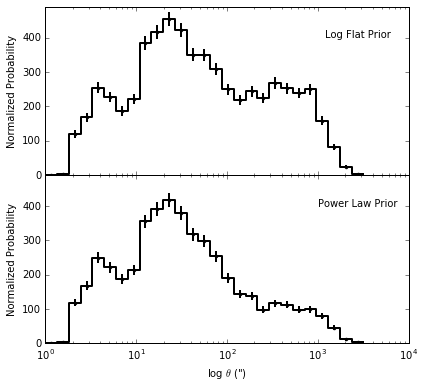

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))

bins = np.linspace(0, 3.5, 28)

TGAS_power_law_good = TGAS_power_law[TGAS_power_law['P_posterior'] > 0.99]
TGAS_log_flat_good = TGAS_log_flat[TGAS_log_flat['P_posterior'] > 0.99]




#### LOG FLAT ####
vals, bins = np.histogram(np.log10(TGAS_log_flat_good['theta']), bins=bins)
#ax[1].plot(10**bins[1:], vals, ls='steps', color='k', linewidth=2.0)
center = 10**((bins[:-1] + bins[1:]) / 2)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[0].plot(X, Y, color='k', linewidth=2.0)
ax[0].errorbar(center, vals, yerr=yerr, fmt='.', capsize=0, color='k', elinewidth=2)



### POWER LAW ###
vals, bins = np.histogram(np.log10(TGAS_power_law_good['theta']), bins=bins)
# ax[0].plot(10**bins[1:], vals, ls='steps', color='k', linewidth=2.0)
center = 10**((bins[:-1] + bins[1:]) / 2)
left,right = 10**bins[:-1],10**bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals,vals]).T.flatten()
yerr = np.sqrt(vals)
ax[1].plot(X, Y, color='k', linewidth=2.0)
ax[1].errorbar(center, vals, yerr=yerr, fmt='.', capsize=0, color='k', elinewidth=2)






ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_xticklabels([])

# ax[0].set_yscale('log')
# ax[1].set_yscale('log')

ax[0].set_ylim(10.0, 490.0)
ax[1].set_ylim(10.0, 490.0)
ax[0].set_yticks(np.linspace(0,400,5))
ax[1].set_yticks(np.linspace(0,400,5))

ax[1].set_xlabel(r'log $\theta$ (")')
ax[0].set_ylabel(r'Normalized Probability')
ax[1].set_ylabel(r'Normalized Probability')

ax[0].text(1.2e3, 400.0, "Log Flat Prior")
ax[1].text(1.0e3, 400.0, "Power Law Prior")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../figures/TGAS_theta_distribution.pdf')
#plt.show()

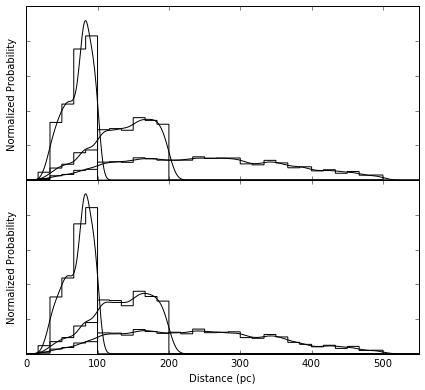

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))

idx = reduce(np.intersect1d, 
             [np.where(dist_log_flat_good < 500.0)[0],
              np.where(s_log_flat_good < 5.0e4)[0],
              np.where(s_log_flat_good > 5.0e3)[0]])

dist_log_flat_100_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<100.0], bw_method=0.3)
dist_log_flat_200_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<200.0], bw_method=0.2)
dist_log_flat_500_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<500.0], bw_method=0.1)

tmp_dist = np.linspace(0.0, 550.0, 500)
ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<100.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_100 = dist_log_flat_100_kde(tmp_dist)
ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<200.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_200 = dist_log_flat_200_kde(tmp_dist)
ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<500.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_500 = dist_log_flat_500_kde(tmp_dist)



idx = reduce(np.intersect1d, 
             [np.where(dist_power_law_good < 500.0)[0],
              np.where(s_power_law_good < 5.0e4)[0],
              np.where(s_power_law_good > 5.0e3)[0]])

dist_power_law_100_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<100.0], bw_method=0.3)
dist_power_law_200_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<200.0], bw_method=0.2)
dist_power_law_500_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<500.0], bw_method=0.1)

ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<100.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_100 = dist_power_law_100_kde(tmp_dist)
ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<200.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_200 = dist_power_law_200_kde(tmp_dist)
ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<500.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_500 = dist_power_law_500_kde(tmp_dist)



ax[0].plot(tmp_dist, tmp_prob_log_flat_100, color='k')
ax[0].plot(tmp_dist, tmp_prob_log_flat_200, color='k')
ax[0].plot(tmp_dist, tmp_prob_log_flat_500, color='k')
ax[1].plot(tmp_dist, tmp_prob_power_law_100, color='k')
ax[1].plot(tmp_dist, tmp_prob_power_law_200, color='k')
ax[1].plot(tmp_dist, tmp_prob_power_law_500, color='k')


ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

ax[0].set_xlim(0,550.0)
ax[1].set_xlim(0,550.0)

ax[1].set_xlabel('Distance (pc)')
ax[0].set_ylabel('Normalized Probability')
ax[1].set_ylabel('Normalized Probability')

plt.tight_layout()
plt.subplots_adjust(hspace=0)

plt.show()

In [15]:
def calc_integrand(dist, theta, dist_kde, s_kde):
    """
    This function is to calculate the integrand for the integral over distance
    
    Parameters
    ----------
    dist : float
        Distance (pc)
    theta : float
        Angular separation (arcsec)
    dist_kde : scipy gaussian_kde
        KDE based on the distance distribution observed
    s_kde : scipy gaussian_kde
        KDE based on a particular binary population model
        
    Returns
    -------
    integrand : float
        Integrand of the equation
    
    """
    
    # Get the separation in Rsun
    s = (theta / 3600.0 * np.pi/180.0) * (dist * c.pc_to_cm / c.Rsun_to_cm)
        
    # Get probability from KDE - KDE is in log-space
    P_s = s_kde.evaluate((np.log10(s))) / s / np.log(10.)

    # Projected separation is above 1.0e7 Rsun
    P_s[np.where(s > 4.41e7)] = 0.0

#     # Calculate normalization constant
#     s_min = 10.0 * (1.0/3600.0 * np.pi/180.0) * dist * (c.pc_to_cm / c.Rsun_to_cm)
#     s_max = np.min([1.0 * (np.pi/180.0) * dist * (c.pc_to_cm / c.Rsun_to_cm), 4.41e7])
#     norm = 1.0 / calc_P_s_norm(s_min, s_max, s_kde)[0]
    
    # Get the distance probability
    P_dist = dist_kde.evaluate((dist))

    # Calculate integrand
    integrand = P_s * dist * P_dist# * norm

    return integrand



def calc_integral(theta, dist_min, dist_max, dist_kde, s_kde):
    """
    Calculate the integral over distance of all binaries that 
    could match the observed angular separation, theta.
    
    Parameters
    ----------
    theta : float
        Angular separation (asec)
    dist_min, dist_max : float
        Min, max distance of integration
    dist_kde : scipy gaussian_kde
        KDE to represent distance distribution of a sample
    s_kde : scipy gaussian_kde
        KDE to represent projected physical separation distribution of a binary population

    Returns
    -------
    P_theta : float
        Value of integration
    """
    
    args = theta, dist_kde, s_kde
        
    val = quad(calc_integrand, dist_min, dist_max, args=args, epsrel=1.0e-4)
    
    return val[0]


def calc_theta_norm(theta_min, theta_max, dist_min, dist_max, dist_kde, s_kde):
    
    args = dist_min, dist_max, dist_kde, s_kde
    
    norm = quad(calc_integral, theta_min, theta_max, args=args)
    
    return norm[0]
    

In [17]:
P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='log_flat')
log_flat_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)

P_binary.generate_binary_set(num_sys=100000, ecc_prob='thermal', a_prob='power_law')
power_law_sep_kde = gaussian_kde(np.log10(P_binary.binary_set['proj_sep']), bw_method=0.05)

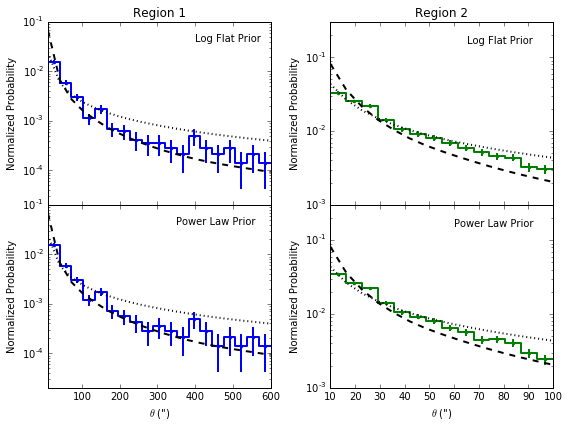

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))




##### Blue Region #####

num_samples = 20
xmin, xmax = 10, 600
dist_min, dist_max = 0.0, 100.0
tmp_theta = np.linspace(xmin, xmax, num_samples)
# tmp_theta = 10**np.linspace(np.log10(xmin), np.log10(xmax), num_samples)
P_theta = np.zeros(num_samples)
binwidth = (tmp_theta[1]-tmp_theta[0])


# Power law sample #
# Our pairs
idx = reduce(np.intersect1d,
             [np.where(dist_power_law_good < 100.0)[0],
              np.where(TGAS_power_law_good['theta'] < 600.0)[0],
              np.where(TGAS_power_law_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(TGAS_power_law_good['theta'][idx], bins=tmp_theta)
yerr = np.sqrt(vals)/len(idx)/binwidth
center = (tmp_theta[:-1] + tmp_theta[1:]) / 2
left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals/(1.0*len(idx))/binwidth,vals/(1.0*len(idx))/binwidth]).T.flatten()
ax[1,0].plot(X, Y, color='b', linewidth=2.0)
# ax[0,0].plot(bins[1:], vals/(1.0*len(idx))/binwidth, ls='steps', color='k', linewidth=2.0)
ax[1,0].errorbar(center, vals/(1.0*len(idx))/binwidth, yerr=yerr, fmt='.', capsize=0, color='b', elinewidth=2)

# Power Law distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_100_kde, power_law_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_100_kde, power_law_sep_kde)
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_200_kde, power_law_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_200_kde, power_law_sep_kde)
ax[1,0].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)

# Log Flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_100_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_100_kde, log_flat_sep_kde)
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_200_kde, log_flat_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_200_kde, log_flat_sep_kde)
ax[1,0].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)



    
# Log flat sample #
# Our pairs
idx = reduce(np.intersect1d,
             [np.where(dist_log_flat_good < 100.0)[0],
              np.where(TGAS_log_flat_good['theta'] < 600.0)[0],
              np.where(TGAS_log_flat_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(TGAS_log_flat_good['theta'][idx], bins=tmp_theta)
yerr = np.sqrt(vals)/len(idx)/binwidth
center = (tmp_theta[:-1] + tmp_theta[1:]) / 2
left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals/(1.0*len(idx))/binwidth,vals/(1.0*len(idx))/binwidth]).T.flatten()
ax[0,0].plot(X, Y, color='b', linewidth=2.0)
# ax[1,0].plot(bins[1:], vals/(1.0*len(idx))/binwidth, ls='steps', color='k', linewidth=2.0)
ax[0,0].errorbar(center, vals/(1.0*len(idx))/binwidth, yerr=yerr, fmt='.', capsize=0, color='b', elinewidth=2)

# Power Law distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_100_kde, power_law_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_100_kde, power_law_sep_kde)
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_200_kde, power_law_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_200_kde, power_law_sep_kde)
ax[0,0].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)

# Log Flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_100_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_100_kde, log_flat_sep_kde)
#     P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_200_kde, log_flat_sep_kde)
# theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_200_kde, log_flat_sep_kde)
ax[0,0].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)












##### Green Region #####


num_samples = 15
xmin, xmax = 10, 100
dist_min, dist_max = 0.0, 500.0
tmp_theta = np.linspace(xmin, xmax, num_samples)
# tmp_theta = 10**np.linspace(np.log10(xmin), np.log10(xmax), num_samples)
P_theta = np.zeros(num_samples)
binwidth = (tmp_theta[1]-tmp_theta[0])


# Power law sample #
# Our pairs
idx = reduce(np.intersect1d,
             [np.where(dist_power_law_good < 500.0)[0],
              np.where(TGAS_power_law_good['theta'] < 100.0)[0],
              np.where(TGAS_power_law_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(TGAS_power_law_good['theta'][idx], bins=tmp_theta)
yerr = np.sqrt(vals)/len(idx)/binwidth
center = (tmp_theta[:-1] + tmp_theta[1:]) / 2
left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals/(1.0*len(idx))/binwidth,vals/(1.0*len(idx))/binwidth]).T.flatten()
ax[1,1].plot(X, Y, color='g', linewidth=2.0)
# ax[0,1].plot(bins[1:], vals/(1.0*len(idx))/binwidth, ls='steps', color='k', linewidth=2.0)
ax[1,1].errorbar(center, vals/(1.0*len(idx))/binwidth, yerr=yerr, fmt='.', capsize=0, color='g', elinewidth=2)

# Power Law distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_200_kde, power_law_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_200_kde, power_law_sep_kde)
ax[1,1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)

# Log Flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_power_law_200_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_power_law_200_kde, log_flat_sep_kde)
ax[1,1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)



    
# Log flat sample #
# Our pairs
idx = reduce(np.intersect1d,
             [np.where(dist_log_flat_good < 500.0)[0],
              np.where(TGAS_log_flat_good['theta'] < 100.0)[0],
              np.where(TGAS_log_flat_good['theta'] > 10.0)[0]])
vals, bins = np.histogram(TGAS_log_flat_good['theta'][idx], bins=tmp_theta)
yerr = np.sqrt(vals)/len(idx)/binwidth
center = (tmp_theta[:-1] + tmp_theta[1:]) / 2
left,right = bins[:-1],bins[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([vals/(1.0*len(idx))/binwidth,vals/(1.0*len(idx))/binwidth]).T.flatten()
#ax[1,1].plot(bins[1:], vals/(1.0*len(idx))/binwidth, ls='steps', color='k', linewidth=2.0)
ax[0,1].plot(X, Y, color='g', linewidth=2.0)
ax[0,1].errorbar(center, vals/(1.0*len(idx))/binwidth, yerr=yerr, fmt='.', capsize=0, color='g', elinewidth=2)

# Power Law distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_200_kde, power_law_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_200_kde, power_law_sep_kde)
ax[0,1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dashed', linewidth=2.0)

# Log Flat distribution
for i in np.arange(num_samples):
    P_theta[i] = calc_integral(tmp_theta[i], dist_min, dist_max, dist_log_flat_200_kde, log_flat_sep_kde)
theta_norm = calc_theta_norm(xmin, xmax, dist_min, dist_max, dist_log_flat_200_kde, log_flat_sep_kde)
ax[0,1].plot(tmp_theta, P_theta / theta_norm, color='k', linestyle='dotted', linewidth=2.0)





for i in np.arange(2):
    for j in np.arange(2):
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylabel('Normalized Probability')

for i in np.arange(2):
    ax[0,i].set_xticklabels([])
    ax[i,0].set_xlim(10.0, 600.0)
    ax[i,1].set_xlim(10.0, 100.0)

ax[0,0].set_ylim(2.0e-5, 0.1)
ax[1,0].set_ylim(2.0e-5, 0.1)
ax[0,1].set_ylim(1.0e-3, 0.3)
ax[1,1].set_ylim(1.0e-3, 0.3)

ax[1,0].set_xlabel(r'$\theta$ (")')
ax[1,1].set_xlabel(r'$\theta$ (")')
        
ax[0,0].set_title('Region 1')
ax[0,1].set_title('Region 2')


ax[0,0].text(400.0, 0.04, "Log Flat Prior")
ax[1,0].text(350.0, 0.04, "Power Law Prior")
ax[0,1].text(65.0, 0.15, "Log Flat Prior")
ax[1,1].text(60.0, 0.15, "Power Law Prior")




plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('../figures/TGAS_theta_dist.pdf')
#plt.show()

In [5]:
# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8')]

tgas_full = np.array([], dtype=dtype)

for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)
    
    

    tgas = np.zeros(len(tgas_tmp), dtype=dtype)

    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']
    tgas['dec'] = tgas_tmp['dec']
    tgas['mu_ra'] = tgas_tmp['pmra']
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']
    tgas['mu_dec'] = tgas_tmp['pmdec']
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']
    tgas['plx'] = tgas_tmp['parallax']
    tgas['plx_err'] = tgas_tmp['parallax_error']

    tgas_full = np.append(tgas_full, tgas)

../data/TGAS/TgasSource_000-000-000.csv


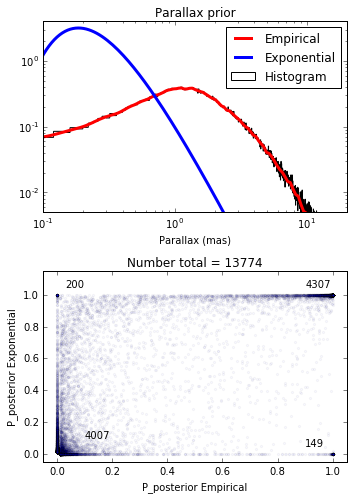

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(5,7))


parallax.plx_kde = None
parallax.set_plx_kde(tgas_full, bandwidth=0.01, method='scipy_kde')


xmin, xmax = 0.01, 100
x = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)
ax[0].hist(tgas_full['plx'], histtype='step', color='k', bins=10000, normed=True, range=(0,200), label='Histogram')
ax[0].plot(x, parallax.get_plx_prior(x, method='scipy_kde'), color='r', linewidth=3, label='power_law')
ax[0].plot(x, parallax.get_plx_prior(x, prior='log flat'), color='b', linewidth=3, label='log flat')
ax[0].set_title('Parallax prior')

ax[0].set_xscale('log')
ax[0].set_xlim(0.1,20)
ax[0].set_yscale('log')
ax[0].set_ylim(5.0e-3, 4.0)
ax[0].set_xlabel('Parallax (mas)')

ax[0].legend()







ax[1].scatter(compare['P_posterior_1'], compare['P_posterior_2'], marker='.', alpha=0.03, rasterized=True)

ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.15)

ax[1].set_xlabel('P_posterior power_law')
ax[1].set_ylabel('P_posterior log flat')


# Print numbers at bottom right and top left
n_bottom_left = 0
n_bottom_right = 0
n_top_left = 0
n_top_right = 0

for i in np.arange(len(compare)):
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] > 0.9: n_top_right = n_top_right+1
    if compare[i]['P_posterior_1'] > 0.9 and compare[i]['P_posterior_2'] < 0.1: n_bottom_right = n_bottom_right+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] > 0.9: n_top_left = n_top_left+1
    if compare[i]['P_posterior_1'] < 0.1 and compare[i]['P_posterior_2'] < 0.1: n_bottom_left = n_bottom_left+1

        
ax[1].text(0.9, 0.05, n_bottom_right)
ax[1].text(0.1, 0.1, n_bottom_left)
ax[1].text(0.03, 1.05, n_top_left)
ax[1].text(0.9, 1.05, n_top_right)
        
ax[1].set_title("Number total = " + str(len(compare)))
    
plt.tight_layout()
plt.savefig('../figures/P_posterior_plx_compare.pdf')
#plt.show()

In [22]:
from astropy.table import Table
import pickle


# Read in sample from TGAS table
dtype = [('ID','<i8'),('tyc','S11'),('hip','<i8'),('ra','<f8'),('dec','<f8'),('mu_ra','<f8'),('mu_dec','<f8'), \
     ('mu_ra_err','<f8'),('mu_dec_err','<f8'),('plx','<f8'),('plx_err','<f8'), \
     ('mu_ra_mu_dec_cov','<f8'),('mu_ra_plx_cov','<f8'),('mu_dec_plx_cov','<f8'),('d_Q','<f8'),('noise','<f8')]

tgas_full = np.array([], dtype=dtype)

#for i in np.arange(16):
for i in np.arange(1):
    if i < 10:
        filename = ('../data/TGAS/TgasSource_000-000-00' + str(i) + '.csv')
    else:
        filename = ('../data/TGAS/TgasSource_000-000-0' + str(i) + '.csv')

    print filename
    tgas_tmp = Table.read(filename, format='csv', guess=True)



    tgas = np.zeros(len(tgas_tmp), dtype=dtype)
                                                  # Gaia units
    tgas['ID'] = tgas_tmp['source_id']
    tgas['tyc'] = tgas_tmp['tycho2_id']
    tgas['hip'] = tgas_tmp['hip']
    tgas['ra'] = tgas_tmp['ra']                   # degrees
    tgas['dec'] = tgas_tmp['dec']                 # degrees
    tgas['mu_ra'] = tgas_tmp['pmra']              # mas/yr
    tgas['mu_ra_err'] = tgas_tmp['pmra_error']    # mas/yr
    tgas['mu_dec'] = tgas_tmp['pmdec']            # mas/yr
    tgas['mu_dec_err'] = tgas_tmp['pmdec_error']  # mas/yr
    tgas['plx'] = tgas_tmp['parallax']            # mas
    tgas['plx_err'] = tgas_tmp['parallax_error']  # mas
    tgas['mu_ra_mu_dec_cov'] = tgas_tmp['pmra_pmdec_corr']*tgas_tmp['pmra_error']*tgas_tmp['pmdec_error']
    tgas['mu_ra_plx_cov'] = tgas_tmp['parallax_pmra_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmra_error']
    tgas['mu_dec_plx_cov'] = tgas_tmp['parallax_pmdec_corr']*tgas_tmp['parallax_error']*tgas_tmp['pmdec_error']
    tgas['d_Q'] = tgas_tmp['astrometric_delta_q']
    tgas['noise'] = tgas_tmp['astrometric_excess_noise_sig']

    tgas_full = np.append(tgas_full, tgas)



print TGAS_power_law[TGAS_power_law['HIP_ID_1'] != 0]['TYC_ID_1']

../data/TGAS/TgasSource_000-000-000.csv
['0' '0' '0' ..., '0' '0' '0']


In [28]:



idx = np.where(tgas_full['hip'] != 0)[0]

print np.where(tgas_full['tyc'][idx] != '0')[0]

[]
